# trainTWO model8_GALAXY

WITH SENTENCE : 푸른 하늘 은하수

galaxyTWO = {0:'bright', 1:'group'}

- galaxyTWO.h5(1): 200/200 // epoch=50 // acc:100%
- galaxyTWO.h5(2): 400/400 // epoch=50 // acc:100%
- galaxyTWO.h5(3): 600/600 // epoch=50 // acc:99%
- galaxyTWO.h5(4):       epoch=50
- galaxyTWO.h5(5):      epoch=50

In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from itertools import chain

galaxyTWO = {0:'bright', 1:'group'}
actions = []

for v in galaxyTWO.values():
    actions.append(v)
print(actions)

['bright', 'group']


In [22]:
data = np.concatenate([
                       # bright : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/galaxyTWO/two_SL_bright_1636360773.npy'),
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/galaxyTWO/two_SL_bright_1636361649.npy'),
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/galaxyTWO/two_SL_bright_1636362182.npy'),
                       # group : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/galaxyTWO/two_SL_group_1636360773.npy'),
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/galaxyTWO/two_SL_group_1636361649.npy'),
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/galaxyTWO/two_SL_group_1636362182.npy')
], axis=0)

data.shape

(1140, 10, 144)

In [23]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1140, 10, 143)
(1140,)


In [24]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1140, 2)

In [25]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1026, 10, 143) (1026, 2)
(114, 10, 143) (114, 2)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                53248     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 55,394
Trainable params: 55,394
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
33/33 [==============================] - 2s 15ms/step - loss: 24.6186 - acc: 0.5595 - val_loss: 15.9113 - val_acc: 0.4737

Epoch 00001: val_acc improved from -inf to 0.47368, saving model to models/model.h5
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 6.1546 - acc: 0.6472 - val_loss: 0.9880 - val_acc: 0.9386

Epoch 00002: val_acc improved from 0.47368 to 0.93860, saving model to models/model.h5
Epoch 3/50
33/33 [==============================] - 0s 8ms/step - loss: 1.1471 - acc: 0.9220 - val_loss: 0.8716 - val_acc: 0.9298

Epoch 00003: val_acc did not improve from 0.93860
Epoch 4/50
33/33 [==============================] - 0s 8ms/step - loss: 0.7404 - acc: 0.9717 - val_loss: 1.6553 - val_acc: 0.9474

Epoch 00004: val_acc improved from 0.93860 to 0.94737, saving model to models/model.h5
Epoch 5/50
33/33 [==============================] - 0s 8ms/step - loss: 0.8483 - acc: 0.9620 - val_loss: 0.8037 - val_acc: 0.9825

Epoch 00005: val_acc improved from

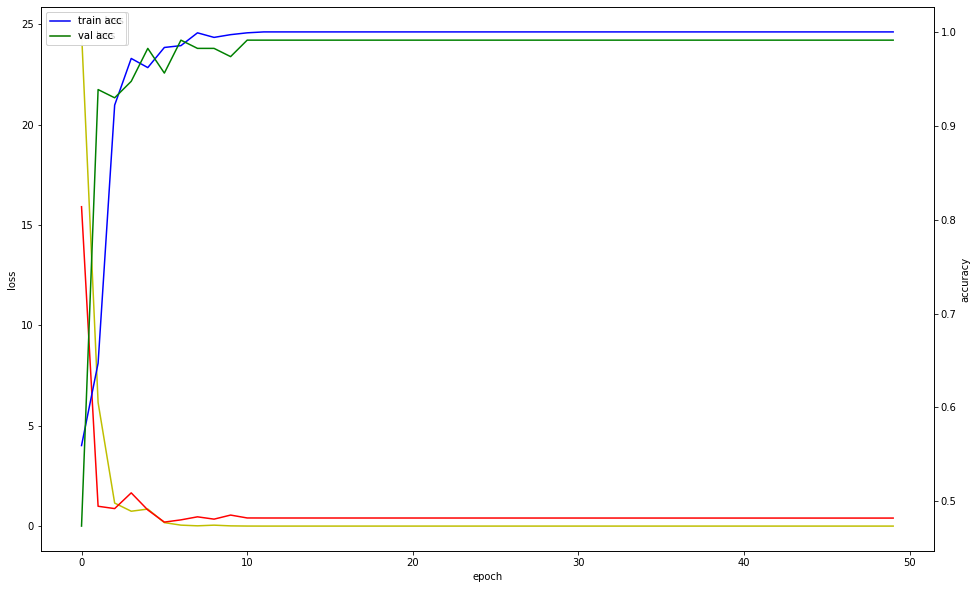

In [28]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [29]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[58,  1],
        [ 0, 55]],

       [[55,  0],
        [ 1, 58]]])

In [30]:
from keras.models import load_model

model.save('galaxyTWO.h5')

from google.colab import files
files.download('galaxyTWO.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>